# Imports

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopandas.tools import sjoin
import geopandas as gpd

In [44]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(42)

# Load districts

In [45]:
X_train = pd.read_csv("../../data/raw/train_values.csv")
y_train = pd.read_csv("../../data/raw/train_labels.csv")
districts = pd.read_csv("../../data/raw/districts.csv", skiprows=[0], sep=";", decimal=",")

In [46]:
districts

,dcode,district,cases_absolute,cases_total,cases_relative
0,7,Dhankuta,4491,996588,0.4506
1,9,Sankhuwasabha,4966,996588,0.4983
2,10,Bhojpur,9242,996588,0.9274
3,11,Solukhumbhu,17000,996588,1.7058
4,12,Okhaldhunga,36480,996588,3.6605
5,13,Khotang,12678,996588,1.2721
6,20,Sindhuli,62900,996588,6.3115
7,21,Ramechhap,54345,996588,5.4531
8,22,Dolakha,57691,996588,5.7889
9,23,Sindhupalchowk,83589,996588,8.3875


In [47]:
#X_train = X_train.iloc[:100000] # max 260601
#y_train = y_train.iloc[:100000] # max 260601

In [48]:
#sample_size = y_train.shape[0]

# Map geographical data to districts
Strategy: Retrieve the shapefile or GeoJSON data for the districts of Nepal and perform geocoding based on the shapefile's boundaries using the geopandas library -> most accurate method. See [administrative boundary datasets for Nepal](https://data.humdata.org/dataset/administrative-boundaries-of-nepal), provided by the Humanitarian Data Exchange (HDX) and used in this project.

In [49]:
# Path to the downloaded district boundaries file (replace with your file path)
file_path = "../../data/raw/31_eq_affected_district_boundaries/Gaupalika_Nagarpalika 31 EQ Affected Districts.shp"
# Read the district boundaries file into a GeoDataFrame
gdf_districts = gpd.read_file(file_path)
# All column names to lowercase
gdf_districts.columns = map(str.lower, gdf_districts.columns)
# Replace district abbreviation with full district name
gdf_districts.loc[gdf_districts['district'] == 'Kavre', 'district'] = 'Kavrepalanchowk'
# Select only the columns we need
gdf_districts = gdf_districts[['dcode', 'district', 'geometry']]

In [50]:
# Dissolve the polygons based on the 'district' attribute
dissolved_districts = gdf_districts.dissolve(by='district')
# Calculate the centroid of each district boundary and create a new GeoDataFrame
dissolved_districts = dissolved_districts.assign(geometry=dissolved_districts.centroid)
# Extract latitude, longitude and altitude
dissolved_districts['latitude'] = dissolved_districts['geometry'].centroid.y
dissolved_districts['longitude'] = dissolved_districts['geometry'].centroid.x
# Reindex
dissolved_districts.reset_index(inplace=True)

In [51]:
dissolved_districts

,district,geometry,dcode,latitude,longitude
0,Arghakhanchi,POINT (409571.756 3088052.705),51,3.088053e+06,409571.756301
1,Baglung,POINT (426759.826 3136583.982),45,3.136584e+06,426759.825988
2,Bhaktapur,POINT (642335.630 3062963.304),26,3.062963e+06,642335.629635
3,Bhojpur,POINT (804271.782 3010893.843),10,3.010894e+06,804271.782189
4,Chitwan,POINT (543089.050 3051933.691),35,3.051934e+06,543089.049990
5,Dhading,POINT (594662.446 3093171.806),30,3.093172e+06,594662.446424
6,Dhankuta,POINT (830923.622 2990403.944),7,2.990404e+06,830923.622196
7,Dolakha,POINT (716887.649 3076030.139),22,3.076030e+06,716887.648819
8,Gorkha,POINT (577663.770 3133385.988),36,3.133386e+06,577663.770413
9,Gulmi,POINT (432119.864 3108447.112),46,3.108447e+06,432119.863630


In [52]:
# Merge the district GeoDataFrame with the districts DataFrame
geocoded_districts = pd.merge(districts, dissolved_districts, on=['district', 'dcode']).rename(columns={"geometry": "loc"}).reindex(['dcode','district', 'loc', 'latitude','longitude', 'cases_absolute', 'cases_total', 'cases_relative'], axis=1)

In [53]:
# Print the merged DataFrame with geocoded information
geocoded_districts

,dcode,district,loc,latitude,longitude,cases_absolute,cases_total,cases_relative
0,7,Dhankuta,POINT (830923.622 2990403.944),2.990404e+06,830923.622196,4491,996588,0.4506
1,9,Sankhuwasabha,POINT (823967.888 3055813.003),3.055813e+06,823967.887554,4966,996588,0.4983
2,10,Bhojpur,POINT (804271.782 3010893.843),3.010894e+06,804271.782189,9242,996588,0.9274
3,11,Solukhumbhu,POINT (768535.264 3068706.453),3.068706e+06,768535.263574,17000,996588,1.7058
4,12,Okhaldhunga,POINT (739586.412 3025872.434),3.025872e+06,739586.412295,36480,996588,3.6605
5,13,Khotang,POINT (776458.721 3008726.920),3.008727e+06,776458.721339,12678,996588,1.2721
6,20,Sindhuli,POINT (692825.736 3010873.276),3.010873e+06,692825.736390,62900,996588,6.3115
7,21,Ramechhap,POINT (715309.737 3045843.189),3.045843e+06,715309.737315,54345,996588,5.4531
8,22,Dolakha,POINT (716887.649 3076030.139),3.076030e+06,716887.648819,57691,996588,5.7889
9,23,Sindhupalchowk,POINT (671458.833 3089631.707),3.089632e+06,671458.832953,83589,996588,8.3875


In [54]:
# save updated district
geocoded_districts.to_csv("../../data/processed/geocoded_districts.csv", index=False)

# Map geo_level_1_id to district

In [55]:
# calculate geo level stats
X_train_count = X_train["geo_level_1_id"].value_counts().reset_index().rename({"index": "geo_level_1_id", "geo_level_1_id": "count_absolute"}, axis=1)
X_train_count["count_total"] = X_train_count["count_absolute"].sum()
X_train_count["count_relative"] = X_train_count["count_absolute"] / X_train_count["count_total"] * 100

In [56]:
# sort appearance of geo_level_1_id by it`s absolute count for comparison and geo_level_1_id mapping
X_train_count.sort_values(by="count_absolute", inplace=True, ascending=False, ignore_index=True)

In [57]:
# sort appearance of districts by it`s absolute count for comparison and geo_level_1_id mapping
geocoded_districts.sort_values(by="cases_absolute", inplace=True, ascending=False, ignore_index=True)

### Plot district vs. geo_level_1_id distribution

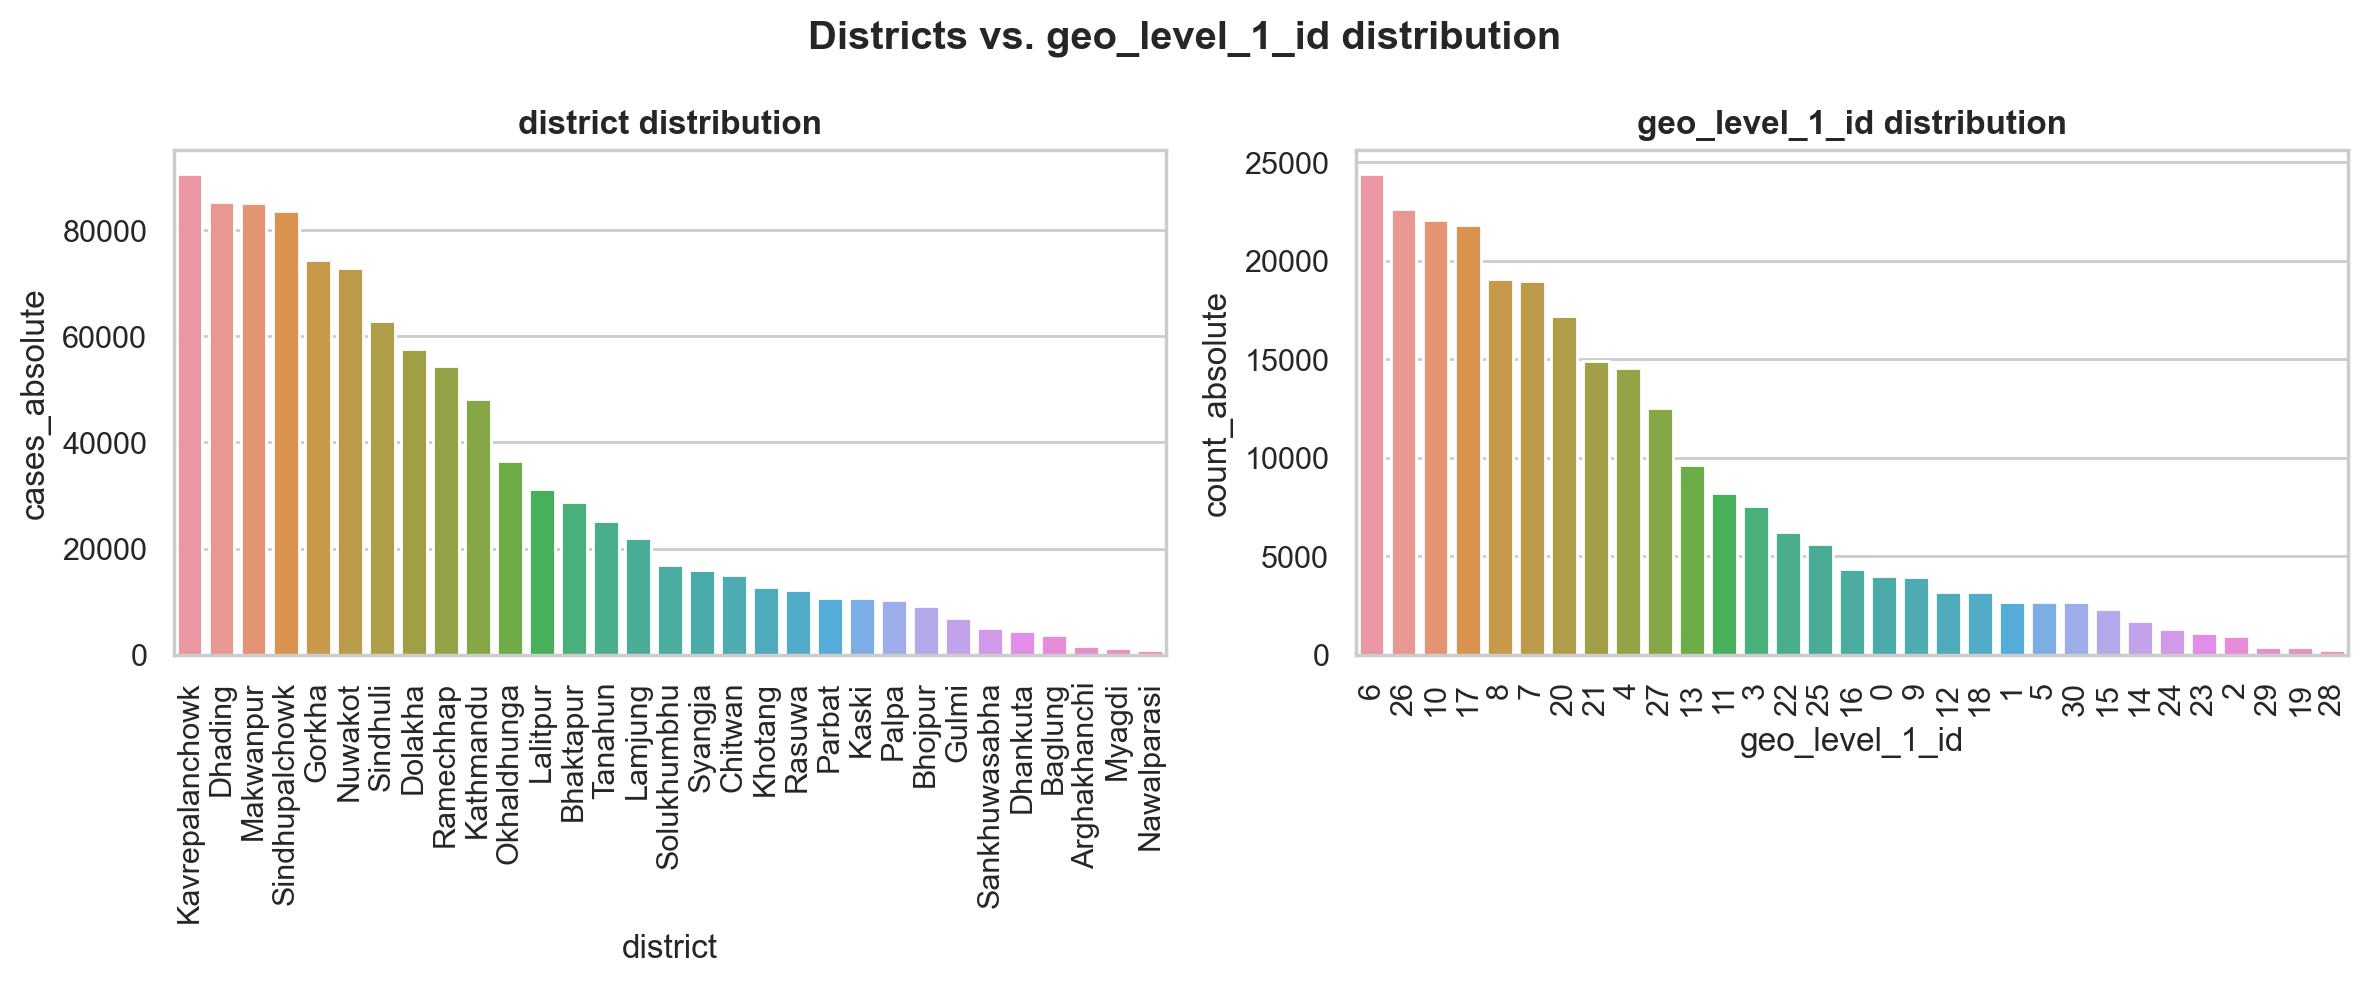

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot district cases distribution
# Change dcode from int to string --> otherwise seaborn plots it as a float
geocoded_districts["dcode"] = geocoded_districts["dcode"].astype(str)
# Plot
sns.barplot(data=geocoded_districts, x="district", y="cases_absolute", ax=ax[0])
# Set title
ax[0].set_title("district distribution", fontweight="bold")
# Rotate xticks
ax[0].tick_params(axis='x', rotation=90)

# Plot data districts distribution
# Change geo_level_1_id from int to string --> otherwise seaborn plots it as a float
X_train_count["geo_level_1_id"] = X_train_count["geo_level_1_id"].astype(str)
# Plot
sns.barplot(data=X_train_count, x="geo_level_1_id", y="count_absolute", ax=ax[1])
# Set title
ax[1].set_title("geo_level_1_id distribution", fontweight="bold")
# Rotate xticks
ax[1].tick_params(axis='x', rotation=90)

# Set title
fig.suptitle("Districts vs. geo_level_1_id distribution", fontweight="bold")

plt.tight_layout()
plt.show()

**Findings:** The distribution of districts and geo_level_1_id is very similar but not exactly the same as we can see above in the plot and also in the realitve distribution numbers. However, it is at least worth a try to map the geocoded information, being langitude, longitude and district name to the actual train dataset as new features using the geo_level_1_id as a key. This key is already present in the train dataset and can be mapped to the actual district name by comparing the distribution of the train dataset and the geocoded districts.

Note: This assumption was made because the survey was conducted in exactly 31 districts of Nepal and the train dataset contains exactly 31 geo_level_1_id's. More over additional survey data is made publicly available by the actual nepalese government containing information about the actual number of cases, the survey response rate, in each district. Using this information we can compare the distributions, which should be the same in relative numbers, and map the actual district names to the train dataset. Having that information we can use it to add geocoded information about the district directly without using just a simple categoric id.

### Conclusion: Merge geo_level_1_id to geocoded_districts

In [59]:
# Add geo_level_1_id to geocoded_districts as a key to merge with X_train
geocoded_districts["geo_level_1_id"] = X_train_count["geo_level_1_id"]
# Move geo_level_1_id to the front
temp_cols=geocoded_districts.columns.tolist()
new_cols=temp_cols[-1:] + temp_cols[:-1]
geocoded_districts=geocoded_districts[new_cols]

In [60]:
geocoded_districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   geo_level_1_id  31 non-null     object  
 1   dcode           31 non-null     object  
 2   district        31 non-null     object  
 3   loc             31 non-null     geometry
 4   latitude        31 non-null     float64 
 5   longitude       31 non-null     float64 
 6   cases_absolute  31 non-null     int64   
 7   cases_total     31 non-null     int64   
 8   cases_relative  31 non-null     float64 
dtypes: float64(3), geometry(1), int64(2), object(3)
memory usage: 2.3+ KB


In [61]:
# Save updated district
geocoded_districts.to_csv("../../data/processed/geocoded_districts.csv", index=False)

# Build function adding geocoded information to X_train

In [72]:
def get_geocoded_info(df, geo_path, drop_key=False):
    """
    Get and add geocoded information to X_train. The geocoded information is the district name, latitude and longitude. The district name is mapped to the geo_level_1_id of X_train. The latitude and longitude are mapped to the district name. The geocoded information is added as new features to X_train.

    :param df: X_train without geocoded information.
    :type df: pandas.DataFrame
    :param geo_df: Pandas Dataframe containing the geocoded information. Must contain the columns 'geo_level_1_id', 'district', 'latitude' and 'longitude'.
    :type geo_df: pandas.DataFrame
    :param drop_key: Drop key, geo_level_1_id, after merging, defaults to False.
    :type drop_key: bool, optional

    :return: X_train with geocoded information
    :rtype: pandas.DataFrame
    """
    # Load geocoded districts
    geo_df = pd.read_csv(geo_path)
    # Make sure key column is of the same type
    df["geo_level_1_id"] = df["geo_level_1_id"].astype(str)
    geo_df["geo_level_1_id"] = geo_df["geo_level_1_id"].astype(str)
    # Only select relevant columns
    geo_df = geo_df[["geo_level_1_id", 'district', 'latitude','longitude']]
    # Merge X_train with geocoded_districts
    df = pd.merge(df, geo_df, on="geo_level_1_id")
    if drop_key:
        # Drop geo_level_1_id
        df.drop("geo_level_1_id", axis=1, inplace=True)

    return df

In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  object
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [73]:
# Add geocoded information to X_train
geo_path = "../../data/processed/geocoded_districts.csv"
geocoded_X_train = get_geocoded_info(X_train, geo_path, drop_key=False)

In [74]:
geocoded_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 42 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   geo_level_1_id                          260601 non-null  object 
 2   geo_level_2_id                          260601 non-null  int64  
 3   geo_level_3_id                          260601 non-null  int64  
 4   count_floors_pre_eq                     260601 non-null  int64  
 5   age                                     260601 non-null  int64  
 6   area_percentage                         260601 non-null  int64  
 7   height_percentage                       260601 non-null  int64  
 8   land_surface_condition                  260601 non-null  object 
 9   foundation_type                         260601 non-null  object 
 10  roof_type                               2606